In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jsw-clean-s/jsw_clean1.csv


In this project I have shown how to use ML for stock market prediction. I have used last 3 months data from NSE.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


file_path1 ='/kaggle/input/jsw-clean-s/jsw_clean1.csv'
#file_path1 ='/kaggle/input/marutic/maruti_clean.csv'
data1 = pd.read_csv(file_path1)


Defined a function named pre_pros to preprocess the data before using it. In this part one can create more new features and clean the data

In [3]:
def pre_pros(data):
    data['date'] = pd.to_datetime(data['date'])
    data['n_exp'] = pd.to_datetime(data['n_exp'])
    data['n_of_day'] = (data['n_exp'] - data['date']).dt.days
    data['pcr_change'] = (data['Peter_o_change']/data['Collin_oi_change'])
    data['pc_cnt'] = (data['Peter_avg_cnt']/data['Collin_avg_cnt'])
    # Sort data by Date1
    data = data.sort_values('date')
    # Shift the 'Open' column to get the next day's open price as the target
    data['Next_Open'] = data['OPEN'].shift(-1)
    # Drop the last row as it will have NaN in 'Next_Open'
    #data = data.dropna()
    data['dirn'] = np.where((data['Next_Open'] - data['CLOSE']) > 10, 0, 
                                np.where((data['Next_Open'] - data['CLOSE']) < -10, 1, 2))
    return data
#data=pre_pros(data)
data1=pre_pros(data1)
data_let=data1.copy()
data1.drop(data1.index[-1], inplace=True)
data1.tail()

,Unnamed: 0,date,n_exp,nearest_exp,Peter_o_change,Collin_oi_change,Peter_toi,Collin_toi,Peter_w_str,Collin_w_str,...,OPEN,HIGH,LOW,close,CLOSE,n_of_day,pcr_change,pc_cnt,Next_Open,dirn
58,58,2024-08-06,2024-08-29,2024-08-29,213975,-183600,4518450,10255275,852.184172,918.885494,...,867.05,893.05,867.05,884.00,884.00,23,-1.165441,0.510427,899.00,0
59,59,2024-08-07,2024-08-29,2024-08-29,133650,-629775,4652100,9625500,871.756864,937.304839,...,899.00,910.65,895.00,906.45,906.45,22,-0.212219,0.611138,900.00,2
60,60,2024-08-08,2024-08-29,2024-08-29,-133650,591975,4518450,10217475,874.237385,927.020610,...,900.00,902.95,883.40,887.55,887.55,21,-0.225770,0.648465,896.05,2
61,61,2024-08-09,2024-08-29,2024-08-29,259875,-101250,4778325,10116225,878.229167,932.694332,...,896.05,914.75,889.00,905.10,905.10,20,-2.566667,0.551220,904.80,2
62,62,2024-08-12,2024-08-29,2024-08-29,392175,-358425,5170500,9757800,890.096282,939.907988,...,904.80,926.20,898.10,917.35,917.35,17,-1.094162,0.425076,925.00,2


The create_lag_features function is designed to generate lagged versions of specified columns in a DataFrame. Lagging is a common technique in time series analysis where past values of a variable are used as features for predicting future values.

In [4]:
def create_lag_features(data, target_cols, lag_steps=3):
    for col in target_cols:
        for i in range(1, lag_steps + 1):
            data[f'{col}_lag_{i}'] = data[col].shift(i)
    return data
target_cols = ['pcr_change', 'pc_cnt', 'Peter_w_str', 'Collin_w_str']
features = ['n_of_day', 'Peter_w_str', 
            'Collin_w_str', 'HIGH', 'LOW', 
            'OPEN','pcr_change','pc_cnt',
            'Peter_o_change','Collin_toi','Peter_toi']

# Apply lag feature creation to the dataset
#data = create_lag_features(data, target_cols=target_cols, lag_steps=4)
#data = data.dropna()
data1 = create_lag_features(data1, target_cols=target_cols, lag_steps=4)
data1 = data1.dropna()
data1.tail()

,Unnamed: 0,date,n_exp,nearest_exp,Peter_o_change,Collin_oi_change,Peter_toi,Collin_toi,Peter_w_str,Collin_w_str,...,pc_cnt_lag_3,pc_cnt_lag_4,Peter_w_str_lag_1,Peter_w_str_lag_2,Peter_w_str_lag_3,Peter_w_str_lag_4,Collin_w_str_lag_1,Collin_w_str_lag_2,Collin_w_str_lag_3,Collin_w_str_lag_4
58,58,2024-08-06,2024-08-29,2024-08-29,213975,-183600,4518450,10255275,852.184172,918.885494,...,0.387558,0.367126,844.177842,884.715777,907.645459,895.619894,929.028253,951.016297,973.915829,942.289205
59,59,2024-08-07,2024-08-29,2024-08-29,133650,-629775,4652100,9625500,871.756864,937.304839,...,0.526043,0.387558,852.184172,844.177842,884.715777,907.645459,918.885494,929.028253,951.016297,973.915829
60,60,2024-08-08,2024-08-29,2024-08-29,-133650,591975,4518450,10217475,874.237385,927.020610,...,0.668238,0.526043,871.756864,852.184172,844.177842,884.715777,937.304839,918.885494,929.028253,951.016297
61,61,2024-08-09,2024-08-29,2024-08-29,259875,-101250,4778325,10116225,878.229167,932.694332,...,0.510427,0.668238,874.237385,871.756864,852.184172,844.177842,927.020610,937.304839,918.885494,929.028253
62,62,2024-08-12,2024-08-29,2024-08-29,392175,-358425,5170500,9757800,890.096282,939.907988,...,0.611138,0.510427,878.229167,874.237385,871.756864,852.184172,932.694332,927.020610,937.304839,918.885494


In [5]:
scaler = MinMaxScaler()
scaled_features = features + [f'{col}_lag_{i}' for col in target_cols for i in range(1, 4)]
#data[scaled_features] = scaler.fit_transform(data[scaled_features])
data1[scaled_features] = scaler.fit_transform(data1[scaled_features])


Predicted: 928.7675170898438, Actual: 927.0
Predicted: 918.6910400390625, Actual: 875.5
Predicted: 896.7166137695312, Actual: 890.0
Predicted: 898.7684936523438, Actual: 895.0
Predicted: 890.5625, Actual: 870.0
Predicted: 895.3753662109375, Actual: 880.0
Predicted: 896.537841796875, Actual: 909.9
Predicted: 900.5774536132812, Actual: 895.05
Predicted: 900.306396484375, Actual: 908.95
Predicted: 922.4373779296875, Actual: 937.55
Predicted: 935.0680541992188, Actual: 919.9
Predicted: 920.6912841796875, Actual: 884.0
Predicted: 892.7420043945312, Actual: 867.05
Predicted: 888.3226928710938, Actual: 899.0
Predicted: 898.8507080078125, Actual: 900.0
Predicted: 899.9859008789062, Actual: 896.05
Predicted: 898.4708862304688, Actual: 904.8
Predicted: 916.2117309570312, Actual: 925.0
RMSE: 17.61286423558954
MAE: 13.469921875000004
R²: 0.17353702365308687


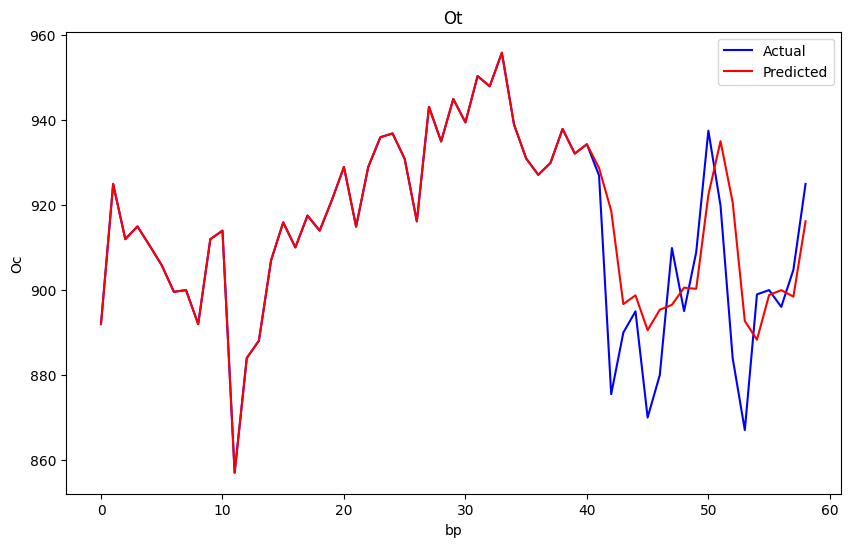

<Figure size 1000x600 with 0 Axes>

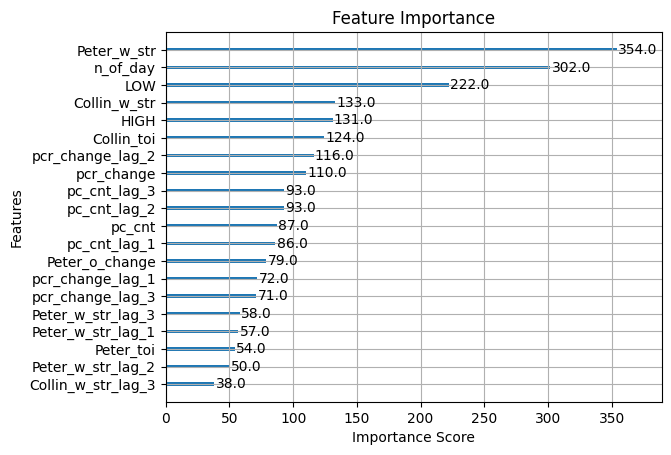

In [6]:
# Split into features (X) and target (y)
#data_let=data1[features]
features += [f'{col}_lag_{i}' for col in target_cols for i in range(1, 4)]
X = data1[features]
y = data1['Next_Open']
#y = data1['dirn']
#X_tata = data1[features]
#y_tata = data1['Next_Open']
# Split into train and test sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
# Convert the data into DMatrix format required by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)
dtest2 = xgb.DMatrix(X, label=y, feature_names=features)
#dtest1 = xgb.DMatrix(X_tata, label=y_tata, feature_names=features)

# Define the model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': .1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=10000)

# Make predictions on the test set
predictions = model.predict(dtest)
predictions2 = model.predict(dtest2)
model.save_model('xgboost_model_jswls.json')
# Print predictions with actual values
for i in range(len(predictions)):
   print(f"Predicted: {predictions[i]}, Actual: {y_test.iloc[i]}")
# Print predictions with actual values and X_test features


# Calculate and print performance metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')
denormalized_feature = scaler.inverse_transform(X_test)
#dclose = denormalized_feature[:, X_test.columns.get_loc('close')]

#denormalized_feature
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y.values, color='blue', label='Actual')
#plt.plot(dclose, color='green', label='close')  # Replace 'Open' with your desired feature
plt.plot(predictions2, color='red', label='Predicted')


plt.title('Ot')
plt.xlabel('bp')
plt.ylabel('Oc')
plt.legend()
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=20, importance_type='weight', xlabel='Importance Score')
plt.title('Feature Importance')
plt.show()
